In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K

from matplotlib import cm
import matplotlib.pyplot as plt

import scipy.misc
from scipy import ndimage
from scipy import signal

from tensorflow.python.client import device_lib

# Check hardware support
Please make sure that a GPU device is listed. Otherwise please install a GPU-compatible version of tensorflow.

In [ ]:
print(device_lib.list_local_devices())

# Import data

Choose between:

-Importing a demonstration file (recommended for a first use)

In [4]:
import requests

file_id = '1fkw_pJQ0quSKOtrzoDQIoELFQUQb3wkD'

# code from  turdus-merula
# https://stackoverflow.com/a/39225272
    
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    
    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


import os
destination = os.getcwd() + '\demo_axon_data.npy'

if os.path.exists(destination) is False:
    download_file_from_google_drive(file_id, destination)

source_images = np.load(destination)
T  = int(source_images.shape[0])
h  = int(source_images.shape[1])
w  = int(source_images.shape[2])
source_images = source_images.astype(np.float32)

- Importing a H5 or HDF5 file

In [ ]:
image_file = 'file_to_import.mesc' # path to the data file
data_path = 'data/Channel_0' # path to the data

import h5py
with h5py.File(image_file, "r") as f:
    source_images = np.asarray(f[data_path])
T  = int(source_images.shape[0])
h  = int(source_images.shape[1])
w  = int(source_images.shape[2])
source_images = source_images.astype(np.float32)

- Importing a tiff file

In [ ]:
image_file = '.tif'
channel_number = 1

import cv2
source_images = cv2.imreadmulti(image_file)
source_images = np.asarray(data[1])
T  = int(source_images.shape[0])
h  = int(source_images.shape[1])
w  = int(source_images.shape[2])
source_images = source_images.astype(np.float32)

OPTIONAL: display of the image stack statistics

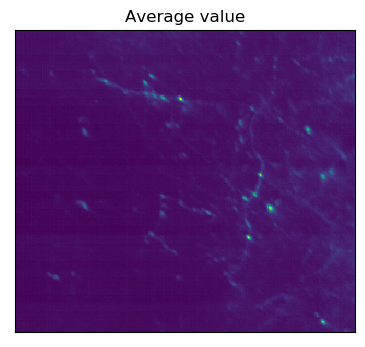

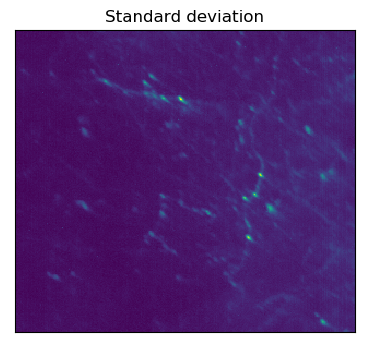

In [5]:
mean_image = np.mean(source_images, axis=0)
plt.figure(dpi=100)
plt.imshow(mean_image)
plt.title('Average value')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.figure(dpi=100)
std_image = np.sqrt(np.var(source_images, axis = 0))
plt.imshow(std_image)
plt.title('Standard deviation')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

## Frames pre-processing
- OPTIONAL: temporally-bin subsequent frames

In [6]:
frame_bin_factor = int(1) # this value can be changed. 1 is for no binning.
if frame_bin_factor > 1:
    num_frame_bins = int(T/frame_bin_factor)
    source_images = np.reshape(source_images[0:int(frame_bin_factor*num_frame_bins)],
                               [num_frame_bins,
                                frame_bin_factor,
                                h,
                                w
                               ]
                               )
    source_images = np.mean(source_images, axis = 1)
    T = source_images.shape[0]

- OPTIONAL: Exclude out-of-focus frames based on autofluorescence levels.
The brightest spots are considered autofluorescence

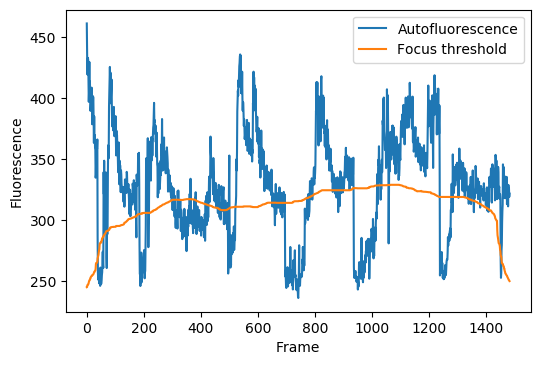

In [7]:
exclude_out_of_focus_frames = True # change to True if frame exclusion is needed

if exclude_out_of_focus_frames:
    quantile_M = 0.99 # quantile of fluorescence to define autofluorescent spots
    autofluo_max_drop = 0.1 # maximum drop, in ratio, of the autofluorescence
    median_filter_size = 601 # size of the time-window (in frames) to compute the median fluorescence
    
    min_image = np.min(source_images, axis = 0)
    min_image = np.reshape(min_image, (h*w,))
    mean_image = np.mean(source_images, axis = 0)
    mean_image = np.reshape(mean_image, (h*w,)) - min_image
    bright_pixels = np.where(mean_image > np.quantile(mean_image, quantile_M))[0]

    source_images = np.reshape(source_images, (T, h*w))
    bright_pixels = source_images[:, bright_pixels] - min_image[bright_pixels]
    autofluo = np.mean(bright_pixels, axis = 1)
    source_images = np.reshape(source_images, (T, h, w))

    plt.figure(dpi=100)
    plt.plot(autofluo)
    autofluo_threshold = np.min(autofluo) + (1 - autofluo_max_drop)*(signal.medfilt(autofluo, median_filter_size) - np.min(autofluo))
    plt.plot(autofluo_threshold)
    plt.xlabel('Frame')
    plt.ylabel('Fluorescence')
    plt.legend(('Autofluorescence', 'Focus threshold'))
    
    selected_frames = np.where(autofluo > autofluo_threshold)[0]
    source_images = source_images[selected_frames]
    T  = int(source_images.shape[0])
else :
    selected_frames = np.arange(T)

## Data Normalization
Scale data between 0 and 1

In [8]:
source_images = source_images - np.quantile(source_images, 0.001) # remove outlier weak pixels. value 0 is equivalent to the min value of the stack
source_images[source_images < 0] = 0
source_images = source_images/np.quantile(source_images, 0.95)/10 # rescale for neuronal network processing

# Define patch splitting operations

Specify the registration and image tiling operations

In [9]:
max_displacement = 5 # maximum displacement, in pixels, between the template images and the image frames.
crop_patch_side = 65 # size of the image tiles, in pixels, for local processing.

## Compute pixel indices for patches
Images a tiled by image patches. Because images are unstable, larger patches with margins have to be extracted.

In [10]:
size_center_patches = crop_patch_side*crop_patch_side

large_patch_side = crop_patch_side + 2*max_displacement # patches that account for image motion
size_large_patches = int(large_patch_side*large_patch_side)

small_tile_side = crop_patch_side - 2*max_displacement
size_small_tiles = int(small_tile_side*small_tile_side)
block_shift = small_tile_side

# compute indices for the large patches
patch_start_x = np.arange(0, w - large_patch_side, block_shift)
if (w - large_patch_side - 1 - patch_start_x[-1] > 5 ): # at least 5 pixels of non-overlap, otherwise not worth creating a tile
    patch_start_x = np.append(patch_start_x, w - large_patch_side-1)
patch_stop_x = patch_start_x + large_patch_side

patch_start_y = np.arange(0, h - large_patch_side, block_shift)
if h - large_patch_side - 1 - patch_start_y[-1] > 5 : # at least 5 pixels of non-overlap, otherwise not worth creating a tile
    patch_start_y = np.append(patch_start_y, h - large_patch_side-1)
patch_stop_y = patch_start_y + large_patch_side

num_large_patches = len(patch_start_x)*len(patch_start_y)

patch_pixel_idx = np.zeros((num_large_patches, size_large_patches), dtype=np.int)
k = 0
for x in range(len(patch_start_x)): 
    x_idx = np.repeat(np.reshape(np.arange(patch_start_x[x], patch_stop_x[x]),
                                 [large_patch_side, 1]), large_patch_side, axis=1) 
    for y in range(len(patch_start_y)):
        y_idx = np.repeat(np.reshape(np.arange(patch_start_y[y], patch_stop_y[y]),
                                                        [1, large_patch_side]), large_patch_side, axis=0)        
        patch_pixel_idx[k, :] = (x_idx.T + y_idx.T*w).ravel()
        k = k + 1

def extract_patch(test_patch_idx, image_stack=source_images):
    x_idx = (patch_pixel_idx[test_patch_idx] - w*np.floor(patch_pixel_idx[test_patch_idx]/w)).astype(int)
    y_idx = np.floor(patch_pixel_idx[test_patch_idx]/w).astype(int)
    test_patch = image_stack[..., y_idx[0]:(y_idx[-1]+1),
                             x_idx[0]:(x_idx[-1]+1)]
    return test_patch

# compute indices for the center patch
center_patch_start_x = patch_start_x + max_displacement
center_patch_stop_x = patch_stop_x - max_displacement

center_patch_start_y = patch_start_y + max_displacement
center_patch_stop_y = patch_stop_y - max_displacement

center_patch_pixel_idx = np.zeros((num_large_patches, size_center_patches), dtype=np.int)
k = 0
for x in range(len(patch_start_x)): 
    x_idx = np.repeat(np.reshape(np.arange(center_patch_start_x[x], center_patch_stop_x[x]),
                                 [crop_patch_side, 1]), crop_patch_side, axis=1) 
    for y in range(len(patch_start_y)):
        y_idx = np.repeat(np.reshape(np.arange(center_patch_start_y[y], center_patch_stop_y[y]),
                                                        [1, crop_patch_side]), crop_patch_side, axis=0)        
        center_patch_pixel_idx[k, :] = (x_idx.T + y_idx.T*w).ravel()
        k = k + 1
        
def extract_center_patch(test_patch_idx, image_stack=source_images):
    x_idx = (center_patch_pixel_idx[test_patch_idx]
             - w*np.floor(center_patch_pixel_idx[test_patch_idx]/w)).astype(int)
    y_idx = np.floor(center_patch_pixel_idx[test_patch_idx]/w).astype(int)
    test_patch = image_stack[..., y_idx[0]:(y_idx[-1]+1), x_idx[0]:(x_idx[-1]+1)]
    return test_patch

def crop_patch(test_patch_idx, image_stack=source_images):
    x_idx = (patch_pixel_idx[test_patch_idx] - w*np.floor(patch_pixel_idx[test_patch_idx]/w)).astype(int)
    y_idx = np.floor(patch_pixel_idx[test_patch_idx]/w).astype(int)

    test_patch = image_stack[..., (y_idx[0]+max_displacement):(y_idx[-1]+1-max_displacement),
                             (x_idx[0]+max_displacement):(x_idx[-1]+1-max_displacement)]
    return test_patch

def fill_center_patch(image, large_patch, large_patch_idx):
    x_idx = (center_patch_pixel_idx[large_patch_idx]
             - w*np.floor(center_patch_pixel_idx[large_patch_idx]/w)).astype(int)
    y_idx = np.floor(center_patch_pixel_idx[large_patch_idx]/w).astype(int)
    #tmp =  large_patch[..., max_displacement:-(max_displacement), max_displacement:-(max_displacement)]

    image[..., y_idx[0]:(y_idx[-1]+1), x_idx[0]:(x_idx[-1]+1)] = large_patch[...,
                                                                            max_displacement:-(max_displacement),
                                                                            max_displacement:-(max_displacement)
                                                                            ]    
    return

def fill_center_patch_from_crop(image, center_patch, patch_idx):
    x_idx = (center_patch_pixel_idx[patch_idx]
             - w*np.floor(center_patch_pixel_idx[patch_idx]/w)).astype(int)
    y_idx = np.floor(center_patch_pixel_idx[patch_idx]/w).astype(int)
    
    image[..., y_idx[0]:(y_idx[-1]+1), x_idx[0]:(x_idx[-1]+1)] = center_patch    
    return image

# compute indices for the small tiles
small_tile_start_x = patch_start_x + 2*max_displacement
small_tile_stop_x = patch_stop_x - 2*max_displacement

small_tile_start_y = patch_start_y + 2*max_displacement
small_tile_stop_y = patch_stop_y - 2*max_displacement

small_tile__pixel_idx = np.zeros((num_large_patches, size_small_tiles), dtype = np.int)
k = 0
for x in range(len(small_tile_start_x)): 
    x_idx = np.repeat(np.reshape(np.arange(small_tile_start_x[x], small_tile_stop_x[x]),
                                 [small_tile_side, 1]), small_tile_side, axis=1) 
    for y in range(len(small_tile_start_y)):
        y_idx = np.repeat(np.reshape(np.arange(small_tile_start_y[y], small_tile_stop_y[y]),
                                                        [1, small_tile_side]), small_tile_side, axis=0)        
        small_tile__pixel_idx[k, :] = (x_idx.T + y_idx.T*w).ravel()
        k = k + 1

def fill_tile_from_crop(image, center_patch, patch_idx):
    x_idx = (small_tile__pixel_idx[patch_idx]
             - w*np.floor(small_tile__pixel_idx[patch_idx]/w)).astype(int)
    y_idx = np.floor(small_tile__pixel_idx[patch_idx]/w).astype(int)
    image[...,
          y_idx[0]:(y_idx[-1]+1),
          x_idx[0]:(x_idx[-1]+1)]= center_patch[...,
                                                max_displacement:(crop_patch_side-max_displacement),
                                                max_displacement:(crop_patch_side-max_displacement)]    
    return image

# Define a source models for individual image patches

Specify the maximum number of sources per image patch

In [11]:
# maximum number sources per image patch
num_sources_per_patch = 8

# number of image displacements to consider for registration:
num_shifts = (2*max_displacement+1)*(2*max_displacement+1)

In [13]:
class SoftNonNegConstraint(tf.keras.constraints.Constraint):
    """ A soft version of the non-negative constraint that prevents gradient explosion"""
    def __init__(self, decay_rate=0.5):
        self.decay_rate = decay_rate
    
    def __call__(self, w):
        w = w * (self.decay_rate + (1-self.decay_rate)*tf.cast(tf.math.greater_equal(w, 0), w.dtype))        
        return w
    
    def get_config(self):
        return  {'decay_rate':self.decay_rate}

class NormRegularizer(tf.keras.regularizers.Regularizer):
    """ A mixed l1-l2 (or 'group-lasso') regularizer for kernels"""
    def __init__(self, l=0.01, l2_axis=0):
        self.l = K.cast_to_floatx(l)
        self.l2_axis = l2_axis
    
    def __call__(self, x):
        r =  (self.l) * tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.square(x),
                                                              axis=self.l2_axis)))
        return r
        
    def get_config(self):
        return {'l': float(self.l), 'l2_axis':self.l2_axis}
    
class ActivityNormRegularizer(tf.keras.regularizers.Regularizer):
    """ A mixed l1-l2 (or 'group-lasso') regularizer for kernel activity"""
    def __init__(self, l=0.01):
        self.l = K.cast_to_floatx(l)
    
    def __call__(self, x):
        # sum over batch and shifts
        r =  (self.l) * tf.reduce_sum(tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(x),
                                                                           axis=0),
                                                             axis=0)))
        return r
        
    def get_config(self):
        return {'l': float(self.l)} 
    
def build_single_patch_conv_model(patch_idx=0, map_reg=1e-4, activity_reg=1e-4):
    """ A neuronal network model for NMF image representation with spatial shifts handled by convolution"""

    input_image_layer = tf.keras.Input(shape=(large_patch_side, large_patch_side))
    reshape_layer = tf.keras.layers.Reshape((large_patch_side, large_patch_side, 1))(input_image_layer)
    
    # convolutive layer for low-level features extraction with invariance to input translation
    conv_layer = tf.keras.layers.Conv2D(8*num_sources_per_patch,
                                        (crop_patch_side, crop_patch_side),
                                        strides = (1, 1),
                                        padding = 'valid',
                                        activation = 'relu',
                                        name = 'conv_layer{}'.format(patch_idx),
                                        use_bias=False)(reshape_layer)
    
    reshape_conv_layer = tf.keras.layers.Reshape((num_shifts,
                                                  8*num_sources_per_patch))(conv_layer)    
    
    analysis_layer1 = tf.keras.layers.Dense(4*num_sources_per_patch,
                                            activation = 'relu',
                                            use_bias = True,
                                            )(reshape_conv_layer)
    
    analysis_layer2 = tf.keras.layers.Dense(2*num_sources_per_patch,
                                            activation = 'relu',
                                            use_bias = True,
                                            )(analysis_layer1)
        
    # source layer
    source_layer = tf.keras.layers.Dense(num_sources_per_patch,
                                         activation = 'relu',
                                         name = 'local_source{}'.format(patch_idx),
                                         activity_regularizer = ActivityNormRegularizer(activity_reg),
                                         )(analysis_layer2)
        
    # linear synthesis layer   
    synthesis_layer = tf.keras.layers.Dense(crop_patch_side*crop_patch_side,
                                            activation = None, # linear integration
                                            use_bias = True, # include the image background                                          
                                            kernel_regularizer=NormRegularizer(l=map_reg,
                                                                               l2_axis=1),
                                            name = 'local_sythesis{}'.format(patch_idx),
                                            bias_constraint = SoftNonNegConstraint(),
                                            kernel_constraint = SoftNonNegConstraint(),
                                            kernel_initializer = tf.keras.initializers.RandomUniform(0, 0.1),
                                            )(source_layer)    
    pred_model = tf.keras.Model(inputs=input_image_layer, outputs = synthesis_layer)
    return pred_model     

# Optimize the neuronal model
Define the loss function when multiple image spatial shifts are considered.

In [14]:
def build_crop_model():
    """ Crop input images with all possible shifts """
    input_image_layer = tf.keras.Input(shape=(large_patch_side, large_patch_side))
    reshape_layer = tf.keras.layers.Reshape((large_patch_side, large_patch_side, 1))(input_image_layer)
    
    crop_layers = []
    for i in range(0, 2*max_displacement+1):
        for j in range(0, 2*max_displacement+1):
            crop_layers.append(tf.keras.layers.Cropping2D(cropping=((i, 2*max_displacement - i),
                                                                    (j, 2*max_displacement - j))
                                                          )(reshape_layer))
    concat_layer = tf.keras.layers.Concatenate(axis=3)(crop_layers)
    crop_reshape_layer = tf.keras.layers.Reshape((crop_patch_side*crop_patch_side, num_shifts))(concat_layer)
    crop_model = tf.keras.models.Model(inputs=input_image_layer, outputs=crop_reshape_layer)    
    return crop_model

crop_model = build_crop_model()

def custom_loss_expectation_multi_crop(y_true, y_pred):
    """ Compute the MSE of image representation with softmax weights of the spatial shifts"""
    y_true_crop = crop_model(y_true)
    y_pred = tf.convert_to_tensor(y_pred)
    y_true_crop = tf.transpose(tf.cast(y_true_crop, y_pred.dtype), perm=[0, 2, 1])
    err_shift = tf.keras.metrics.mean_squared_error(y_pred, y_true_crop)    
    err_shift2 = tf.math.subtract(err_shift, tf.math.reduce_min(err_shift , axis=-1, keepdims=True))    
    b = 0.000001 # scaling factor for the softmax weighting
    loss_weight = tf.math.exp(-err_shift2/(2*b)) + K.epsilon()        
    loss_weight = tf.divide(loss_weight, tf.math.reduce_sum(loss_weight, axis=-1, keepdims=True))
    return tf.math.multiply(err_shift, loss_weight)

Define optimization parameters

In [15]:
train_with_few_frames = True # Whether to use only 
num_train_frames = int(T/5) # number of frames to use for the optimization procedure
n_epochs = 500 # number of outer iterations for optimizing each local neuronal network
batch_size = 32 # number of image frames to process simultaneously. Can be decreased in case of memory issues.
learning_rate = 0.005 # tunes how fast error gradients modify the network weights

## OPTIONAL: Fit a single tile
Can help quickly adapt parameters when the base setup is not appropriate

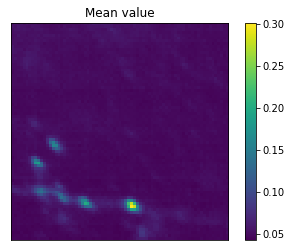

In [16]:
test_patch_idx = int(num_large_patches/3) # set the index of the image patch to process
test_patch = extract_patch(test_patch_idx)
plt.figure()
plt.imshow(np.mean(test_patch, axis = 0))
plt.title('Mean value')
plt.colorbar()
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

In [50]:
# select the sparsest image frames for training
if train_with_few_frames:
    s = np.mean(test_patch, axis = 0)
    s = np.sum(np.sum(np.square(test_patch - s), axis = -1), axis = -1)
    s = np.argsort(s)

    train_t = np.concatenate([s[-1:-num_train_frames:-1], s[:int(np.floor(num_train_frames/4))]])
    train_t = np.sort(train_t)
else:
    train_t = np.arange(T)

# For axons:
regularization_strength = 0.05*np.var(test_patch)

# For dendrites:
#regularization_strength = 0.01*np.var(test_patch)

l_reg = regularization_strength
activity_reg = l_reg*1e-2

m = build_single_patch_conv_model(test_patch_idx, map_reg = l_reg, activity_reg = activity_reg)
m.compile(optimizer = keras.optimizers.Nadam(learning_rate),
          loss = custom_loss_expectation_multi_crop,
          metrics = [])

m.fit(test_patch[train_t],
      test_patch[train_t],
      batch_size=batch_size,
      epochs = n_epochs,
      shuffle = False,
      verbose = 0)

Compare the image predicted by the model to an actual a random frame. Run multiple times for different frames.

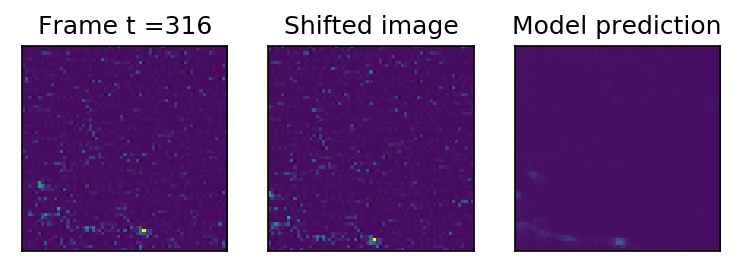

In [46]:
rand_t = np.round(np.random.rand(1)*train_t.size).astype(int)
rand_t = train_t[rand_t[0]]

image_predict = m(test_patch[rand_t:rand_t+1])
losses = [custom_loss_expectation_multi_crop(test_patch[rand_t:rand_t+1], image_predict)
          for k in range(0, image_predict.shape[0])]
best_shift = np.argmin(losses)

dx = int(np.floor(best_shift/(2*max_displacement + 1)))
best_shift_x = dx - max_displacement
dy = best_shift - dx*(2*max_displacement + 1)
best_shift_y = dy - max_displacement

v_min = np.min(test_patch)
v_max = np.max(test_patch)/2

plt.figure(dpi = 150)
crop_image = test_patch[rand_t].squeeze()[max_displacement:-max_displacement,
                                          max_displacement:-max_displacement]
plt.subplot(1, 3, 1)
p = plt.imshow(crop_image, vmin = v_min, vmax = v_max)
plt.title('Frame t ={}'.format(rand_t))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.subplot(1, 3, 2)
crop_images = crop_model(test_patch[rand_t:rand_t+1])
crop_image = np.reshape(crop_images[0, :, best_shift], [crop_patch_side, crop_patch_side])
p = plt.imshow(crop_image, vmin = v_min, vmax = v_max)
plt.title('Shifted image')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.subplot(1, 3, 3)
p = plt.imshow(np.reshape(image_predict[0, best_shift, :], [crop_patch_side,
                                                            crop_patch_side]),
               vmin=v_min, vmax=v_max)
plt.title('Model prediction')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

Display the local source maps and temporal activity

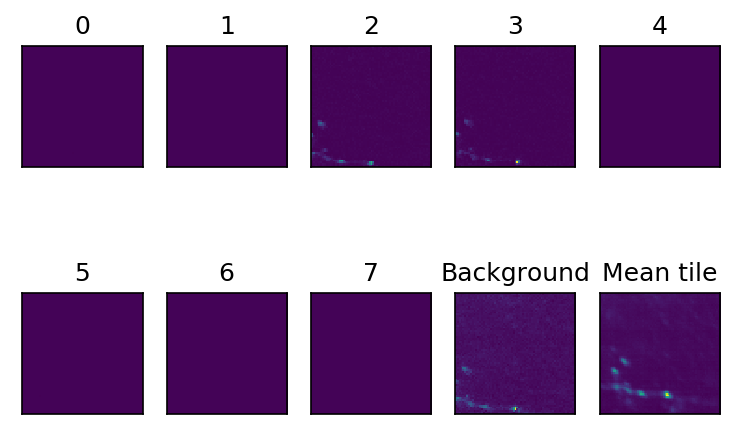

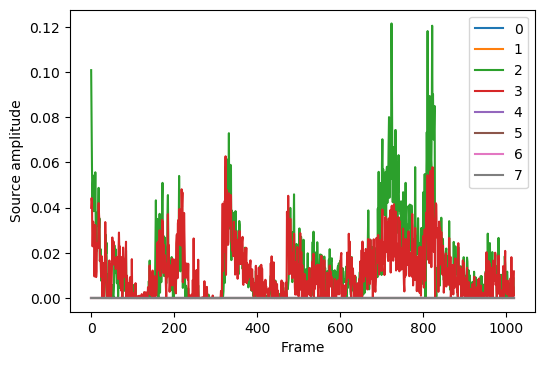

In [48]:
# compute maps
k = K.function(m.get_layer('local_sythesis{}'.format(test_patch_idx)).input,
               m.get_layer('local_sythesis{}'.format(test_patch_idx)).output)

test_input = np.zeros((num_sources_per_patch, num_shifts, num_sources_per_patch))
background_source = np.asarray(k(test_input))
background_source = np.reshape(background_source[:, 0, :],
                               [1, num_sources_per_patch, crop_patch_side, crop_patch_side])

test_input[:, 0, :] = np.eye(num_sources_per_patch)
test_input[:, 0, :] = np.eye(num_sources_per_patch)

source_maps = np.asarray(k(test_input))
source_maps = np.reshape(source_maps[:, 0, :], [num_sources_per_patch,
                                                crop_patch_side,
                                                crop_patch_side])
source_maps = source_maps - background_source

plt.figure(dpi = 150)
for j in range(0, num_sources_per_patch):
    plt.subplot(2, 1 + np.floor((num_sources_per_patch+1)/2), j+1)
    plt.imshow(source_maps[0, j], vmin=source_maps.min(), vmax=source_maps.max())
    ax = plt.gca()
    plt.title(j)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

plt.subplot(2, 1 + np.floor((num_sources_per_patch+1)/2), j+2)
plt.imshow(background_source[0, 0].squeeze())
plt.title('Background')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.subplot(2, 1 + np.floor(num_sources_per_patch+1)/2, j+3)
plt.imshow(np.mean(test_patch, axis = 0))
plt.title('Mean tile')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

# compute amplitudes
get_source_activity = K.function(m.inputs[0],
                                 m.get_layer('local_source{}'.format(test_patch_idx)).output)
source_activities_local = get_source_activity(test_patch)

# take the maximum value among considered image shifts
mean_local_source_activity = np.max(np.mean(source_activities_local,
                                            axis=0),
                                    axis=0)
plt.figure(dpi=100)
plt.plot(np.mean(source_activities_local, axis=1))

plt.xlabel('Frame')
plt.ylabel('Source amplitude')
plt.legend(range(num_sources_per_patch))

# Fit all the image tiles
This could be distributed on a grid of GPUs

In [51]:
models = [] # store local neuronal network models
for i in range(num_large_patches):
    print('Procesing tile #{}'.format(i))
    test_patch = extract_patch(i)
    if train_with_few_frames:
        s = np.mean(test_patch, axis = 0)
        s = np.sum(np.sum(np.square(test_patch - s), axis = -1), axis = -1)
        s = np.argsort(s)

        train_t = np.concatenate([s[-1:-num_train_frames:-1], s[:int(np.floor(num_train_frames/4))]])
        train_t = np.sort(train_t)
    else:
        train_t = np.arange(T)

    # For dendrites:
    #regularization_strength = 0.01*np.var(test_patch)
    
    # For axons:
    regularization_strength = 0.05*np.var(test_patch) # good
    
    l_reg = regularization_strength
    activity_reg = l_reg*1e-2

    m = build_single_patch_conv_model(i, l_reg, activity_reg)
    
    m.compile(optimizer=keras.optimizers.Nadam(learning_rate),
                      loss=custom_loss_expectation_multi_crop,
                      metrics=[])
        
    m.fit(test_patch[train_t],
          test_patch[train_t],
          epochs=n_epochs,
          shuffle=False,
          verbose=0)    
    models.append(m)

Procesing tile #0
Procesing tile #1
Procesing tile #2
Procesing tile #3
Procesing tile #4
Procesing tile #5
Procesing tile #6
Procesing tile #7
Procesing tile #8
Procesing tile #9
Procesing tile #10
Procesing tile #11
Procesing tile #12
Procesing tile #13
Procesing tile #14
Procesing tile #15
Procesing tile #16
Procesing tile #17
Procesing tile #18
Procesing tile #19
Procesing tile #20
Procesing tile #21
Procesing tile #22
Procesing tile #23
Procesing tile #24
Procesing tile #25
Procesing tile #26
Procesing tile #27
Procesing tile #28
Procesing tile #29


Test image prediction when combining all the tiles for a random image frame.
Repeat multiple times for different frames.

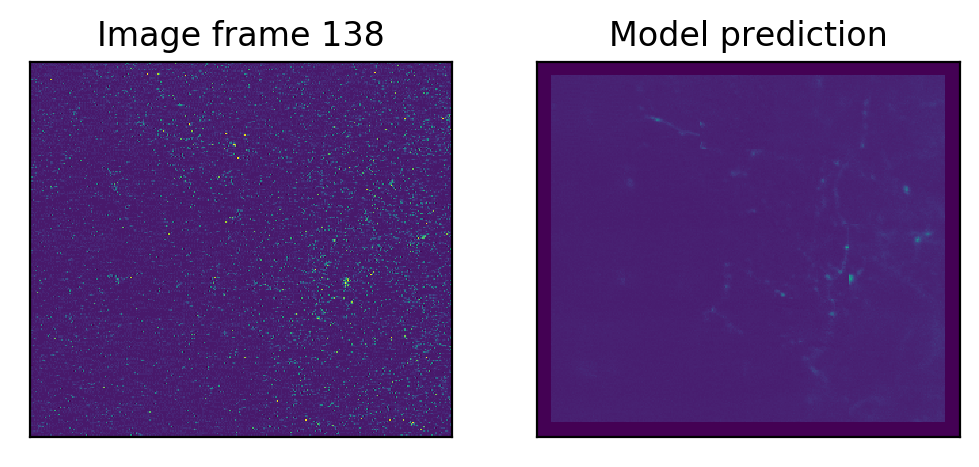

In [56]:
rand_t = np.round(np.random.rand(1)*T).astype(int)
rec = np.zeros((h, w))
for i in range(num_large_patches):
    test_patch = extract_patch(i, source_images[rand_t])
    image_predict = models[i](test_patch)
    losses = custom_loss_expectation_multi_crop(test_patch, image_predict)
    best_shift = np.argmin(losses, axis=1)
    rec = fill_tile_from_crop(rec,
                              np.reshape(image_predict[0, best_shift[0]],
                                         [crop_patch_side, crop_patch_side]),
                              i)        
plt.figure(dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(source_images[rand_t[0]],
           vmin = 0,
           vmax = 0.5)

plt.title('Image frame {}'.format(rand_t[0]))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.subplot(1, 2, 2)
plt.imshow(rec,
           vmin = 0,
           vmax = 0.5)
plt.title('Model prediction')
ax = plt.gca()

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

Record the activity of the source layer

In [57]:
def build_shift_prediction_model(patch_idx):
    """ Neuronal network which predicts the best image spatial shifts """
    input_image_layer = tf.keras.Input(shape=(large_patch_side, large_patch_side))
    reshape_layer = tf.keras.layers.Reshape((large_patch_side, large_patch_side, 1))(input_image_layer)
    
    crop_layers = []
    for i in range(0, 2*max_displacement+1):
        for j in range(0, 2*max_displacement+1):
            crop_layers.append(tf.keras.layers.Cropping2D(cropping=((i, 2*max_displacement - i),
                                                                    (j, 2*max_displacement - j))
                                                          )(reshape_layer))
    concat_layer = tf.keras.layers.Concatenate(axis=3)(crop_layers)
    crop_reshape_layer = tf.keras.layers.Reshape((crop_patch_side*crop_patch_side, num_shifts))(concat_layer)    
    
    
    
    pred_patch = models[patch_idx](input_image_layer)
    msqe_pred = tf.math.reduce_mean(tf.math.squared_difference(pred_patch,
                                                               tf.transpose(crop_reshape_layer, (0, 2, 1))),
                                    axis=-1)
    
    pred_shift = tf.math.argmin(msqe_pred, axis=1)
    
    pred_shift_model = tf.keras.models.Model(inputs=input_image_layer,
                                             outputs=pred_shift)    
    return pred_shift_model

source_activities_local = np.zeros([num_large_patches, T, num_sources_per_patch])
mean_local_source_activity = np.zeros((num_large_patches, num_sources_per_patch))
local_source_shifts = np.zeros((num_large_patches, T))

for p_idx in range(num_large_patches):
    print('Procesing tile #{}'.format(p_idx))
    test_patch = extract_patch(p_idx)
    pred_shift_model = build_shift_prediction_model(p_idx)
    get_source_activity = K.function(models[p_idx].inputs[0],
                                     models[p_idx].get_layer('local_source{}'.format(p_idx)).output)
    source_activity = get_source_activity(test_patch)
    
    for t in range(0, batch_size*(np.floor(T/batch_size).astype(int)), batch_size):        
        pred_shifts = pred_shift_model(test_patch[t:(t+batch_size)]).numpy().astype(int)    
        local_source_shifts[p_idx, t:(t+batch_size)] = pred_shifts
        source_activity_t = [source_activity[t + i, pred_shifts[i], :] for i in range(batch_size)]
        source_activity_t = np.asarray(source_activity_t)
        source_activities_local[p_idx, t:(t+batch_size), :] = source_activity_t
    if t + 1 < T:
        pred_shifts = pred_shift_model(test_patch[(t+1):T]).numpy().astype(int)    
        source_activity_t = [source_activity[t+1 + i, pred_shifts[i], :] for i in range(T-(t+1))]
        source_activity_t = np.asarray(source_activity_t)
        source_activities_local[p_idx, (t+1):T, :] = source_activity_t
        local_source_shifts[p_idx, (t+1):T] = pred_shifts
    mean_local_source_activity[p_idx] = np.mean(source_activities_local[p_idx], axis = 0, keepdims = False)

Procesing tile #0
Procesing tile #1
Procesing tile #2
Procesing tile #3
Procesing tile #4
Procesing tile #5
Procesing tile #6
Procesing tile #7
Procesing tile #8
Procesing tile #9
Procesing tile #10
Procesing tile #11
Procesing tile #12
Procesing tile #13
Procesing tile #14
Procesing tile #15
Procesing tile #16
Procesing tile #17
Procesing tile #18
Procesing tile #19
Procesing tile #20
Procesing tile #21
Procesing tile #22
Procesing tile #23
Procesing tile #24
Procesing tile #25
Procesing tile #26
Procesing tile #27
Procesing tile #28
Procesing tile #29


Compute the source spatial maps

In [59]:
shifted_local_background_source = []
shifted_local_source_maps = []

test_input = np.zeros((num_sources_per_patch, num_shifts, num_sources_per_patch))
test_input[:, int(np.floor(num_shifts/2)), :] = np.eye(num_sources_per_patch)
test_input_background = np.zeros((1, num_shifts, num_sources_per_patch))

for p_idx in range(num_large_patches):
    # compute the mean shift
    mean_x_shift = int(np.mean(np.mod(local_source_shifts[p_idx], 2*max_displacement + 1)) - max_displacement)
    mean_y_shift = int(np.mean(np.floor(local_source_shifts[p_idx]/(2*max_displacement + 1))) - max_displacement)
    
    k = K.function(models[p_idx].get_layer('local_sythesis{}'.format(p_idx)).input,
               models[p_idx].output)


    # read a shifted input to correct for systematic shift so that the mean shift is null in both directions

    r = np.asarray(k(test_input))
    r = r[:, int(np.floor(num_shifts/2)), :]
    
    r = np.swapaxes(r, 0, 1)
    s_maps = np.reshape(r, (crop_patch_side, crop_patch_side, num_sources_per_patch))    

    r = np.asarray(k(test_input_background))
    r = r[:, int(np.floor(num_shifts/2)), :]
    
    r = np.swapaxes(r, 0, 1)
    r = np.reshape(r, (crop_patch_side, crop_patch_side, 1))
    
    # crop r and s_maps
    r = r[(-mean_y_shift+max_displacement):(-mean_y_shift+max_displacement+small_tile_side),
          (-mean_x_shift+max_displacement):(-mean_x_shift+max_displacement+small_tile_side)]
    
    s_maps = s_maps[(-mean_y_shift+max_displacement):(-mean_y_shift+max_displacement+small_tile_side),
                    (-mean_x_shift+max_displacement):(-mean_x_shift+max_displacement+small_tile_side)]
        
    shifted_local_background_source.append(r)
    shifted_local_source_maps.append(s_maps - r)    

# Build a global model combining local sources
 Select only active sources. The threhsold for selection has to be adapted.

Number of selected local sources = 9


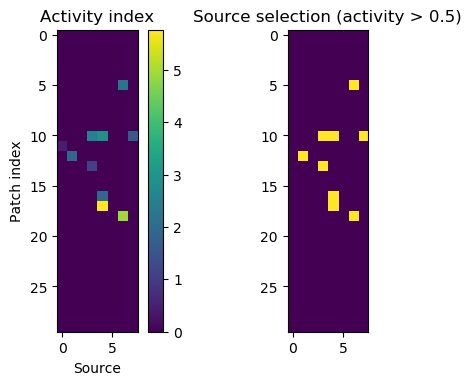

In [62]:
activity_threshold = 0.5 # threshold for selecting local sources for grouping. 5 for dendrites. 0.5 for axons.
correlation_init = 0 # criterion for merging correlated local sources #0.5 for axons

local_source_selection_index = np.zeros((num_large_patches, num_sources_per_patch))
for p_idx in range(num_large_patches):
    for j in range(num_sources_per_patch):
        local_source_selection_index[p_idx, j]  = np.sum(shifted_local_source_maps[p_idx][..., j])*np.mean(source_activities_local[p_idx][:, j])

is_source_selected = local_source_selection_index > activity_threshold
        
total_num_sources_local = (int)(np.sum(is_source_selected))
print('Number of selected local sources = {}'.format(total_num_sources_local))

plt.figure(dpi = 100)
plt.subplot(1, 2, 1)
plt.imshow(local_source_selection_index)
plt.title('Activity index')
plt.colorbar()
plt.xlabel('Source')
plt.ylabel('Patch index')

plt.subplot(1, 2, 2)
plt.imshow(is_source_selected)
plt.title('Source selection (activity > {})'.format(activity_threshold))

selected_local_source_idx = np.where(is_source_selected.ravel() == True)[0]
selected_patch_idx = np.floor(selected_local_source_idx/num_sources_per_patch).astype(int)
selected_source_idx = np.mod(selected_local_source_idx, num_sources_per_patch).astype(int)

Merge local sources based on the temporal correlation of their activity

In [64]:
def affinity_propagation_clustering(similarities,
                                    preferences,
                                    max_iterations=1000,
                                    convergence_iterations=100,
                                    damping_factor=0.9,
                                    no_noise=False):
    """ affinity propagation algorithm based of Frey and Dueck, Science 2009 """
    if similarities.shape[1] == 3:
        N = (np.max([np.max(similarities[:, 0]), np.max(similarities[:, 1])]) + 1).astype(int)
        sim = -np.ones((N, N))*np.inf
        sim[(similarities[:, 0].astype(int), similarities[:, 1].astype(int))] = similarities[:, 2]
    else:
        sim = similarities
        N = sim.shape[0]

    # In case user did not remove degeneracies from the input similarities,
    # avoid degenerate solutions by adding a small amount of noise to the
    # input similarities
    if not no_noise:
        sim = sim + np.random.randn(N, N) * np.finfo(sim.dtype).resolution*100

    # Set preferences on the diagonal of S
    di = np.diag_indices(N)
    sim[di] = preferences

    # Numerical stability -- replace -INF with -realmax
    sim[sim == np.inf] = np.finfo(sim.dtype).max
    sim[sim == -np.inf] = np.finfo(sim.dtype).min
    sim_symmetric =  np.all(sim == sim.T)

    # Allocate space for messages, etc
    diag_sim = sim[di]
    A = np.zeros((N, N))
    R = np.zeros((N, N))
    e = np.zeros((N, convergence_iterations))

    dn = False
    i = -1
    t = 1

    while not dn:
        i += 1
        # Compute responsibilities
        old_Mat = R.copy()
        AS = A + sim
        I = np.argmax(AS, axis = 1)
        Y = AS[(np.arange(N), I)]
        AS[(np.arange(N), I)] = -np.inf
        I2 = np.argmax(AS, axis = 1)
        R = sim - np.reshape(Y, [N, 1])
        R[(np.arange(N), I)] = sim[(np.arange(N), I)] - AS[np.arange(N), I2]
        R = (1 - damping_factor)*R + damping_factor*old_Mat

        # Compute availabilities
        old_Mat = A.copy()

        Rp = np.zeros(R.shape)
        Rp[R > 0] = R[R > 0]
        Rp[(np.arange(N), np.arange(N))] = R[(np.arange(N), np.arange(N))]
        A = np.sum(Rp, axis = 0) - Rp
        dA = A[(np.arange(N), np.arange(N))]
        An = np.zeros(A.shape)
        An[A < 0] = A[A < 0]
        An[(np.arange(N), np.arange(N))] = dA
        A = (1 - damping_factor)*An + damping_factor*old_Mat

        # Check for convergence
        E = (np.diag(A) + np.diag(R)) > 0
        e[:, i%convergence_iterations] = E
        K = np.sum(E)

        if i >= convergence_iterations or i >= max_iterations:
            se = np.sum(e, axis = 1)
            converged = np.all(np.logical_and((se == convergence_iterations), (se == 0)))
            if (converged and K > 0)  or (i == max_iterations):
                dn = True
    if K > 0:
        # identify cluster
        I = np.where(E)[0]
        not_I = np.where(np.logical_not(E))[0]

        cm = np.argmax(sim[:, I], axis = 1)
        cm[I] = np.arange(0, K)
        tmp_idx = I[cm]

        # Refine the final set of exemplars and clusters and return results
        for k in range(K):
            ii = np.where(cm == k)[0]
            # select as new exemplar the item with largest sum of similarities with the cluster instances
            j = np.argmax(np.sum(sim[ii, ii], axis=0))
            I[k] = ii[j]
        not_I = np.setdiff1d(I, np.arange(0, N))
        tmp_dp_sim = np.sum(sim[(not_I, tmp_idx[not_I])])

        tmp_exp_ref = np.sum(diag_sim[I])
        tmp_net_sim = tmp_dp_sim + tmp_exp_ref
    else:
        tmp_idx = np.nan*np.ones(N)
        tmp_net_sim = np.nan
        tmp_exp_ref = np.nan

    net_sim = tmp_net_sim
    dp_sim = tmp_dp_sim
    exp_ref = tmp_exp_ref
    idx = tmp_idx

    return idx.astype(int), net_sim, dp_sim, exp_ref

source_activities_mat = np.swapaxes(source_activities_local, 0, 1)
source_activities_mat = np.reshape(source_activities_mat, (source_activities_mat.shape[0],
                                                           source_activities_mat.shape[1]
                                                           *source_activities_mat.shape[2]))
source_activities_mat = source_activities_mat[..., selected_local_source_idx]

source_corr = np.corrcoef(source_activities_mat.T)
source_corr[np.isnan(source_corr)] = 0


source_sim = source_corr + 1
for i in range(total_num_sources_local):
    source_sim[i, i] = (correlation_init + 1)/total_num_sources_local
cluster_idx = affinity_propagation_clustering(source_sim,
                                              1 + correlation_init,
                                              max_iterations = 5000,
                                              convergence_iterations=200,
                                              no_noise=False,
                                              damping_factor=0.5)[0]
u_cluster_idx = np.unique(cluster_idx)
num_source_clusters = u_cluster_idx.size

source_clusters = []
for i in range(num_source_clusters):
    source_clusters.append(np.where(cluster_idx == u_cluster_idx[i])[0])
print("Number of clusters = {}".format(u_cluster_idx.size))

Number of clusters = 3


## Build merged model with only selected sources

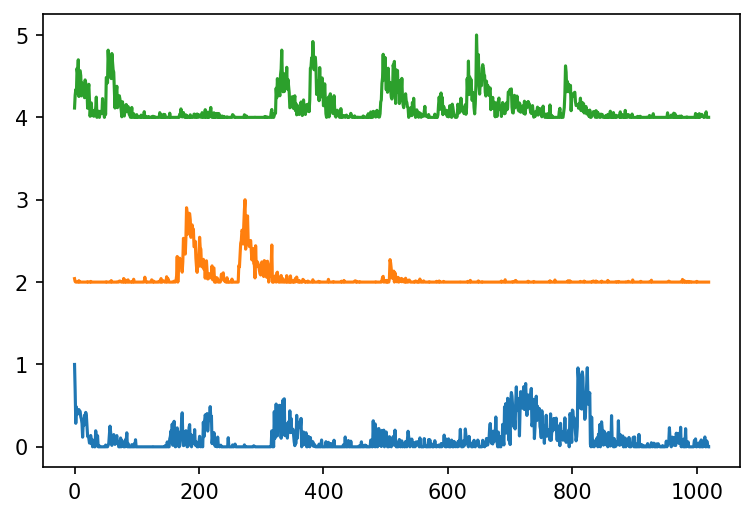

In [65]:
# compute the source mixing weights by singular value decomposition of local source activity
local_source_mixing_weights = np.zeros((total_num_sources_local, num_source_clusters))
local_source_unmixing_weights = np.zeros((num_source_clusters, total_num_sources_local))

for i in range(num_source_clusters):
    ii = source_clusters[i]
    if ii.size > 1:
        cluster_activity = source_activities_mat[:, ii]
        #np.linalg.svd(a, full_matrices=True, compute_uv=True, hermitian=False)
        cluster_activity = source_activities_mat[:, ii]
        #plt.plot(cluster_activity)
        [cluster_u, cluster_s, cluster_vh] = np.linalg.svd(cluster_activity, full_matrices=False)
        proj_activity = np.matmul(cluster_activity, cluster_vh[0, :])
        if np.sum(proj_activity > 0):
            local_source_mixing_weights[ii, i] = cluster_vh[0, :]
        else:
            local_source_mixing_weights[ii, i] = -cluster_vh[0, :]
            proj_activity = -proj_activity
        local_source_unmixing_weights[i, ii] = np.sqrt(np.matmul(proj_activity, cluster_activity)/np.matmul(proj_activity.T, proj_activity))
        
    else:
        local_source_mixing_weights[ii, i] = 1
        local_source_unmixing_weights[i, ii] = 1 

# mix activity from local sources
clusters_activities_mat = np.matmul(source_activities_mat, local_source_mixing_weights)
rec_source_activities_mat = np.matmul(clusters_activities_mat, local_source_unmixing_weights)

def compute_sources_activity(X):
    """ Compute the temporal activity of local sources for an arbitrary image stack"""
    all_source_activities = []
    all_best_shifts = []
    
    for i in range(num_large_patches):
        test_patch = extract_patch(i, X)
        m = models[i]
        image_predict = m(test_patch)
        
        losses = custom_loss_expectation_multi_crop(test_patch, image_predict)        
        best_shift = np.argmin(losses, axis=1)
        all_best_shifts.append(best_shift)               
        
        get_source_activity = K.function(m.inputs[0],
                                 m.get_layer('local_source{}'.format(i)).output)
        source_activity = get_source_activity(test_patch)
        reg_source_activity = np.zeros((source_activity.shape[0], source_activity.shape[2]))
        for t in range(source_activity.shape[0]):
            reg_source_activity[t] = source_activity[t, best_shift[t]]
        all_source_activities.append(reg_source_activity)
        
    return all_source_activities, all_best_shifts

def compute_clusters_activity(X):
    """ Compute the temporal activity of global sources for an arbitrary image stack """
    all_source_activities, all_best_shifts = compute_sources_activity(X)
    all_source_activities = np.concatenate(all_source_activities, axis = 1)
    selected_source_activities = all_source_activities[:, is_source_selected.ravel()]
    clusters_activities = np.matmul(selected_source_activities, local_source_mixing_weights)
    return clusters_activities, all_source_activities, all_best_shifts

def predict_merged_images(X):
    """ Predict images based on the learned model for an arbitrary image stack """
    clusters_activities, all_source_activities, all_best_shifts = compute_clusters_activity(X)
    rec_selected_source_activities = np.matmul(clusters_activities, local_source_unmixing_weights)
    # predict images based on predicted source activities
    rec_image = np.zeros((X.shape[0], h, w))
    for p_idx in range(num_large_patches):
        # retrieve selected sources for that patch
        rec_patch = np.zeros((small_tile_side, small_tile_side))
        rec_patch_activity = np.zeros((X.shape[0],
                                       small_tile_side*small_tile_side,
                                       num_sources_per_patch))
        k = K.function(models[p_idx].get_layer('local_sythesis{}'.format(p_idx)).input,
                       models[p_idx].output)
        test_input = np.zeros((X.shape[0], num_shifts, num_sources_per_patch))
        
        s = np.where(selected_patch_idx == p_idx)[0]
        if s.size > 0:
            for j in s:
                test_input[:, 0, selected_source_idx[j]] = rec_selected_source_activities[:, j]
        r = np.asarray(k(test_input))
        rec_image = fill_tile_from_crop(rec_image,
                                        np.reshape(r[:, 0, :],
                                                   [X.shape[0],
                                                    crop_patch_side,
                                                    crop_patch_side]),
                                        p_idx)                                               
    return rec_image, rec_selected_source_activities

def get_cluster_map(source_idx):
    """ Compute the spatial map for an individual global source """
    source_m = np.zeros((h*w))
    for i in range(num_large_patches):
        ii = np.where(selected_patch_idx == i)[0] # selected local sources for this cluster        
        if ii.size > 0:
            m_i = np.zeros((small_tile_side, small_tile_side))            
            for iii in ii:
                s = selected_source_idx[iii]
                m_i = m_i + shifted_local_source_maps[i][..., s]*local_source_unmixing_weights[source_idx, iii]             
            source_m[small_tile__pixel_idx[i].astype(int)] = m_i.ravel()  
    source_m = np.reshape(source_m, (h, w))
    return source_m

# compute the source spatial maps
global_source_maps = []
for i in range(num_source_clusters):
    global_source_maps.append(get_cluster_map(i))

# compute the global sources activity over time
all_clusters_activities = np.zeros((T, num_source_clusters))
all_best_shifts = np.zeros((T, num_large_patches), dtype=np.int)

t_bin = 256
for t in range(0, T - t_bin, t_bin):
    c_activities, s_activities, best_shifts = compute_clusters_activity(source_images[t:(t+t_bin)])
    all_clusters_activities[t:(t+t_bin)] = c_activities
    best_shifts = np.reshape(np.concatenate(best_shifts), [num_large_patches, t_bin])
    all_best_shifts[t:(t+t_bin)] = best_shifts.T
    
c_activities, s_activities, best_shifts = compute_clusters_activity(source_images[(t+t_bin):])
all_clusters_activities[(t+t_bin):]  = c_activities
best_shifts = np.reshape(np.concatenate(best_shifts), [num_large_patches, best_shifts[0].shape[0]])
all_best_shifts[(t+t_bin):] = best_shifts.T

plt.figure(dpi=150)
for i in range(num_source_clusters):
    plt.plot(2*i + all_clusters_activities[:, i]/np.max(all_clusters_activities[:, i]))

Display the spatial map and the temporal activity for an individual global source 

Text(0.5, 1.0, 'Source amplitude')

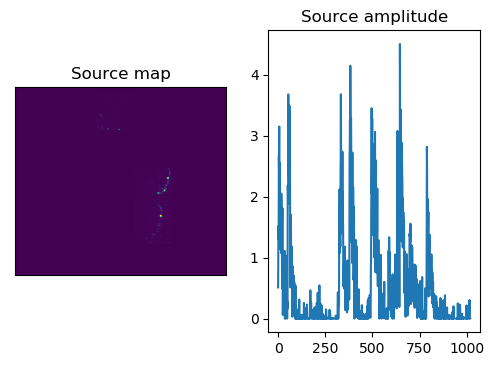

In [70]:
source_index = 2

plt.figure(dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(global_source_maps[source_index])
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.title('Source map')
plt.subplot(1, 2, 2)
plt.plot(all_clusters_activities[:, source_index])
plt.title('Source amplitude')

# Refine source footprints and amplitudes

In [71]:
# stabilize original images before re-estimating footprints and amplitudes
stabilized_images = np.zeros((T, h, w))
for i in range(num_large_patches):
    test_patch = extract_patch(i, source_images)
    shift_patch = crop_model(test_patch)
    # shape (T, numpix, num_shifts)
    shift_patch = np.reshape(shift_patch, [T, crop_patch_side, crop_patch_side, num_shifts])    
    best_shift_patch = np.zeros((T, crop_patch_side, crop_patch_side))
    for t in range(T):
        best_shift_patch[t] = shift_patch[t, :, :, int(all_best_shifts[t, i])]
    stabilized_images = fill_tile_from_crop(stabilized_images, best_shift_patch, i)

In [72]:
def estimate_masks(Y, S, num_iter=200, tol=1e-6):
    '''Estimate footprints by solving argmin_M ||Y - MS||_2/2 s.t. X >= 0 '''
    # uses the FISTA algorithm See Beck and Teboulle 2009
    num_pixels = Y.shape[0]
    num_components = S.shape[0]
    M = np.zeros((num_pixels, num_components))
    U = np.zeros(M.shape)
    YSt = np.matmul(Y, S.T)
    SSt = np.matmul(S, S.T)
    tau = 1/(num_components*np.sqrt(np.sum(np.max(np.square(SSt)))))

    t = 1
    for it in range(num_iter):
        t_prev = t
        t = (1 + np.sqrt(1 + 4*(t**2)))/2

        M_prev = M
        # compute the gradient of the smooth part in U:  (U*S - Y)*S'
        M = np.matmul(U, SSt) - YSt
        M = U - tau*M
        M[M < 0] = 0
        U = M + ((t_prev - 1)/t)*(M - M_prev)
        if (np.mod(it, 4) == 0) and (np.sum(np.square((M - M_prev))) < tol):
            break
    return M


def estimate_amplitudes(Y, M, num_iter=200, tol=1e-6):
    ''' Estimate source amplitude by solving argmin_M ||Y - MS||_2/2 s.t. X >= 0 '''
    # uses the FISTA algorithm See Beck and Teboulle 2009

    TT = Y.shape[1]
    num_components = M.shape[1]

    S = np.zeros((num_components, TT))
    U = np.zeros(S.shape)

    MtM = np.matmul(M.T, M)
    MtY = np.matmul(M.T, Y)

    tau = 1/(np.sqrt(num_components)*np.max(MtM))

    t = 1
    for it in range(num_iter):
        t_prev = t
        t = (1 + np.sqrt(1 + 4*(t**2)))/2

        S_prev = S
        # compute the gradient of the smooth part in U: (U*S - Y)*S'
        S = U - tau*np.matmul(MtM, S) + tau*MtY
        # projection on the feasible set
        S[S < 0] = 0
        S[S > 1] = 1

        U = S + ((t_prev - 1)/t)*(S - S_prev)
        if (np.mod(it, 4) == 0) and (np.sum(np.square((S - S_prev))) < tol):
            break
    return S

stabilized_images = np.reshape(stabilized_images, [T, h*w]).T

num_iter_outter = 10 # number of iterations for the alternating optimization procedure
num_iter_inner = 100 # number of iterations for each amplitude and footprint estimation procedure

S = np.concatenate((np.ones((1, T)), all_clusters_activities.T), axis=0)
S[1:] = S[1:] - np.min(S[1:], axis = 1, keepdims=True)
S = np.divide(S, np.max(S, axis = 1, keepdims=True))
M = estimate_masks(stabilized_images, S, num_iter=num_iter_inner)
    
for it in range(num_iter_outter):
    print('Iteration {}/{}'.format(it, num_iter_outter))
    M = estimate_masks(stabilized_images, S, num_iter=num_iter_inner)
    rec_background = np.matmul(np.reshape(M[:, 0], (h*w, 1)),
                               np.reshape(S[0, :], (1, T)))
    S = estimate_amplitudes(stabilized_images  - rec_background, M[:, 1:], num_iter=num_iter_inner)
    S = np.concatenate((np.ones((1, T)), S), axis=0)

Iteration 0/10
Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10


Text(0, 0.5, 'Amplitude')

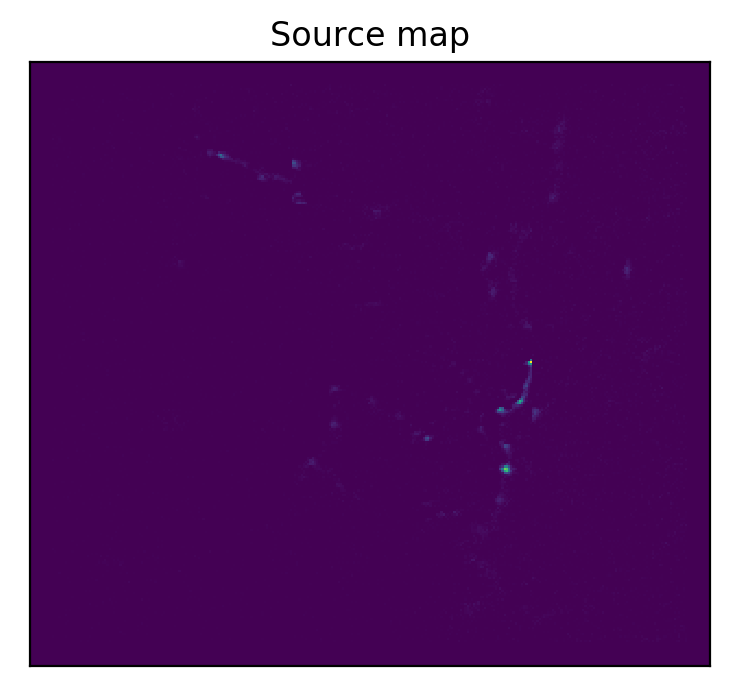

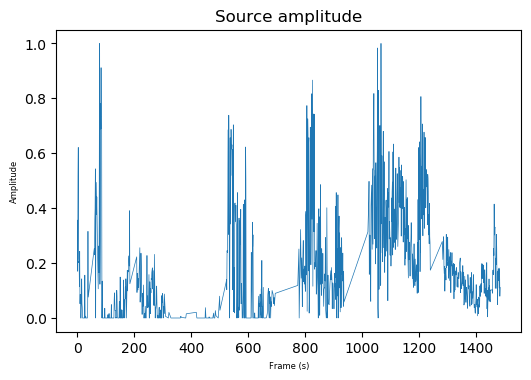

In [96]:
source_index = 1

plt.figure(dpi=200)
plt.imshow(np.reshape(M[:, source_index], (h, w)),
          vmin = 0.005)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.title('Source map')

s_frames = selected_frames[0:T:frame_bin_factor]
plt.figure(dpi=100)
plt.plot(s_frames[:all_clusters_activities.shape[0]],
         S[source_index],
         '-',
         linewidth=0.5)
plt.title('Source amplitude')
plt.xlabel('Frame (s)', fontsize=6)
plt.ylabel('Amplitude', fontsize=6)

Display a prediction of the model

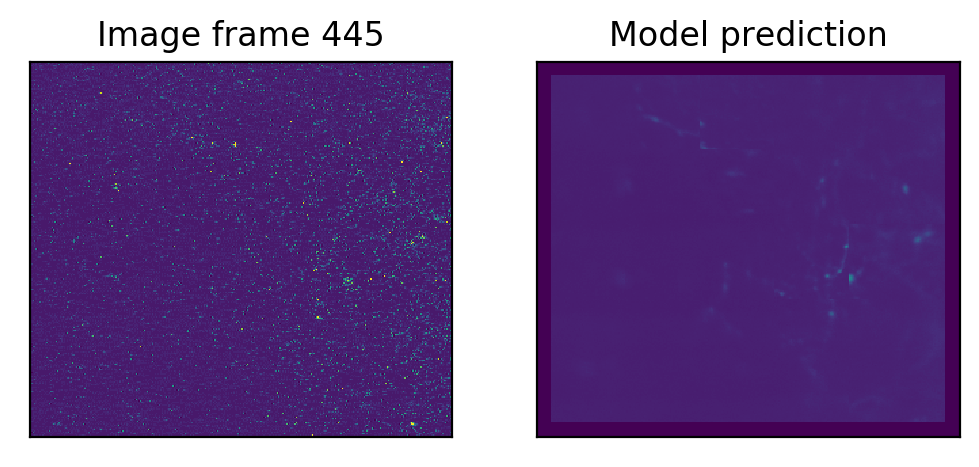

In [97]:
rand_t = np.round(np.random.rand(1)*T).astype(int)
rec = np.reshape(np.matmul(M, S[:, rand_t]), (h, w))

plt.figure(dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(source_images[rand_t[0]],
           vmin = 0,
           vmax = 0.5)

plt.title('Image frame {}'.format(rand_t[0]))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.subplot(1, 2, 2)
plt.imshow(rec,
           vmin = 0,
           vmax = 0.5)
plt.title('Model prediction')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)